In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# 신경망을 이용한 분류(1) : 이진분류

### 영화 리뷰 분류

- IMDB(Internet Movie Database) 리뷰 데이터셋
- 5만개 : 훈련데이터 25000, 테스트데이터 25000
- 2진 분류 : 50% 부정 리뷰, 50% 긍정 리뷰

### 데이터 로드

 - 리뷰가 숫자 시퀀스로 변환되어 있음
 - 각 숫자는 사전에 있는 고유한 단어
 - 가장 자주 나타나는 단어 1만개만 사용하여 데이터 로딩

In [2]:
from keras.datasets import imdb

In [3]:
(train_X, train_y), (test_X, test_y) = imdb.load_data(num_words=10000) #단어 1만개 지정

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
print(len(train_X[0]))
train_X[0][:10] #단어들이 수치화되어서 들어가 있음

218


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [7]:
train_y[0]

1

In [8]:
max([max(seq) for seq in train_X]) #각각의 데이터에서 가장 최대값

9999

In [9]:
word_index = imdb.get_word_index()
len(word_index)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


88584

In [12]:
# print(word_index) #8만개 단어들이 들어가 있음

- word_index를 인덱스, 단어의 형식으로 변경

In [ ]:
reverse_word_index = dict([(value, key) for key, value in word_index.items()])
# print(reverse_word_index)

In [16]:
# 0: 패딩, 1: 문서시작, 2: 사전에 없음 (단어가 3부터 시작함)
# 사전에 없으면 물음표로 가져옴 (가장 자주 나타나는 단어 1만개만 사용 / num_words=10000)
' '.join([reverse_word_index.get(i-3, '?') for i in train_X[0]])

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 데이터 준비

- 신경망에 숫자를 입력으로 줄 수 없으므로, 텐서 형식으로 변환 필요

In [23]:
# 원핫인코딩으로 벡터화 - get dummies 써도 됨
def vectorize_sequences(seq, dimension=10000):
    results = np.zeros((len(seq), dimension))  # 10000차원으로 - 원핫 인코딩
    for i, sq in enumerate(seq):
        for j in sq:
            if j < dimension:  # 시퀀스 값이 지정된 차원보다 작은지 확인
                results[i, j] = 1.0
    return results

In [24]:
X_train = vectorize_sequences(train_X)
X_test = vectorize_sequences(test_X)

In [25]:
X_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [26]:
X_train.shape

(25000, 10000)

In [27]:
train_y[0].dtype

dtype('int64')

In [28]:
train_y[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [29]:
y_train = train_y.astype('float32')
y_train[1].dtype

dtype('float32')

In [30]:
y_test = test_y.astype('float32')

### 1) 신경망 모델 정의


In [43]:
from keras import models, layers

model = models.Sequential([
#     layers.Input(shape=(10000,)),
    layers.Dense(16, activation='relu'), #input_shape 안넣어줘도 됨
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

In [44]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 2) 모델 컴파일

In [45]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

### 3) 모델 훈련 및 검증

- 검증세트 구성

: 모델의 정확도를 측정하기 위해 훈련데이터에서 10000개 샘플을 떼어 검증 세트 구성

In [46]:
X_val = X_train[:10000] #25000개 중 10000개만 사용
X_tr = X_train[10000:]
y_val = y_train[:10000]
y_tr = y_train[10000:]

X_tr.shape, X_val.shape

((15000, 10000), (10000, 10000))

- 모델 훈련

In [47]:
history = model.fit(X_tr, y_tr, epochs=20, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6920 - loss: 0.6135 - val_accuracy: 0.8503 - val_loss: 0.4368
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8847 - loss: 0.3751 - val_accuracy: 0.8807 - val_loss: 0.3316
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9142 - loss: 0.2660 - val_accuracy: 0.8849 - val_loss: 0.2954
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9321 - loss: 0.2144 - val_accuracy: 0.8890 - val_loss: 0.2768
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9428 - loss: 0.1747 - val_accuracy: 0.8584 - val_loss: 0.3518
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9501 - loss: 0.1550 - val_accuracy: 0.8864 - val_loss: 0.2794
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9608 - loss: 0.1281 - val_accuracy: 0.8828 - val_loss: 0.3072
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9623 - loss: 0.1163 - val_accuracy: 0.8849 - v

- 모델 검증 결과: 훈련데이터, 검증데이터

In [48]:
print(history.history['loss'])

[0.5491647720336914, 0.3546293377876282, 0.26263752579689026, 0.21169131994247437, 0.17775189876556396, 0.15196022391319275, 0.13157083094120026, 0.11461063474416733, 0.10085379332304001, 0.08707699924707413, 0.07362821698188782, 0.06317197531461716, 0.05508020147681236, 0.04663356766104698, 0.04042494297027588, 0.032229889184236526, 0.029153481125831604, 0.026214076206088066, 0.021252643316984177, 0.017123183235526085]


### 4) 훈련과 검증 손실 그리기

In [49]:
def draw_metric_plot2(history):
    loss = ['loss', 'val_loss']
    acc = ['accuracy', 'val_accuracy']
    title = ['Loss', 'Accuracy']
    plt.figure(figsize=(10,5))
    for i, item in enumerate([loss, acc]):
        n = len(history.history[item[0]])
        plt.subplot(1,2,i+1)
        plt.plot(history.history[item[0]], label='train')
        plt.plot(history.history[item[1]], label='validation')
        plt.xlabel('epoch')
        plt.ylabel(title[i])
        plt.xticks(range(n), range(1, n+1))
        plt.title(title[i] + ' plot')
        plt.legend()
    plt.show()

- 훈련과 검증 정확도 그래프

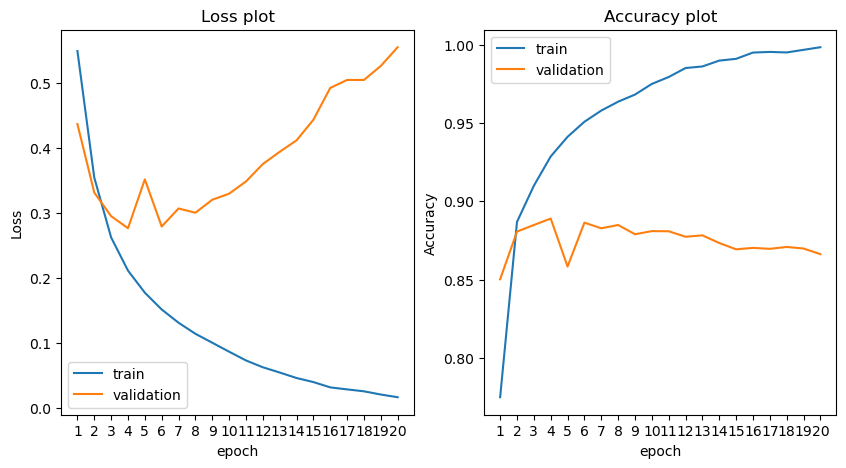

In [50]:
draw_metric_plot2(history)
# 손실 줄었다 늠 / 정확도는 증가하다가 감소

### 5) 모델 튜닝 후 다시 모델 훈련하기
- 에포크는 4로 지정
- 검증 데이터를 포함하여 모델 훈련
- 테스트 데이터로 성능 평가

In [40]:
model = models.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history2 = model.fit(X_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7139 - loss: 0.5612
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9036 - loss: 0.2788
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9259 - loss: 0.2109
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9391 - loss: 0.1765


### 6) 훈련된 모델로 새로운 데이터에 대해 예측하기

In [41]:
pred_proba = model.predict(X_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step


In [42]:
from sklearn.preprocessing import Binarizer

pred = Binarizer(threshold=0.5).fit_transform(pred_proba)
pred_y = pred.reshape(-1)
pred_y.shape

(25000,)

In [52]:
np.sum(y_test == pred_y) / y_test.shape[0]

0.88096

### [연습]

1. 은닉층을 1개 또는 3개의 층으로 사용하고 검증과 테스트의 정확도 비교해보기

2. 층의 은닉 유닛을 추가하거나 줄여보기
  - 32개 유닛, 64개 유닛 등

3. relu 대신에 tanh 활성화 함수 사용해보기

### 과대적합 & 과소적합

- 과소 적합은 학습이 덜된것, 학습을 더 시켜주면 됨(문제는 안됨)

검증데이터에 대한 손실값을 비교한 결과,
-  네트워크 은닉층의 유닛 수가 적은 모델의 경우가 유닛 수가 많은 모델보다 더 나중에 과대적합되기 시작하며, 과대적합이 시작되었을 떄 성능이 더 천천히 감소함


훈련데이터에 대한 손실값을 비교한 결과,
- 네트워크의 은닉층 유닛 수가 클수록 더 빠르게 훈련데이터를 모델링할 수 있으나, 과대적합에 민감해짐(결국 훈련과 검증 손실 사이에 큰 차이가 발생함)




---

#### 과대적합 방지법

- 훈련 데이터를 더 모음
- 네트워크의 용량을 감소시킴
- 가중치 규제를 추가함
    - L1 규제 : regularizers.l1(0.001) (lasso와 유사)
    - L2 규제 : regularizers.l2(0.001) (ridge와 유사)
    - L1, L2 규제 병행: regularizers.l1_l2(l1=0.001, l2=0.001)

- 은닉층에 드롭아웃(Dropout) 층 추가


<과대적합 방지법>
```python
# 1) 가중치 규제
from keras import regularizers
model = models.Sequential([
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')])
```

```python
# 2) 은닉층에 드롭아웃 추가
model = models.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')])
```

### 정리
- 원본 데이터를 신경망에 텐서로 주입하기 위해서는 전처리가 필요함
  - 예. 단어 시퀀스는 이진 벡터로 인코딩

- relu 활성화 함수와 함께 Dense 층을 쌓은 네트워크는 여러 종류의 문제에 적용할 수 있어 자주 사용됨

- 출력 클래스가 2개인 이진 분류 문제에서 네트워크는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층으로 끝나야 함
  - 신경망의 출력은 확률을 나타내는 0과 1사이의 스칼라 값이 됨

- 이진 분류 문제에서 스칼라 시그모이드 출력에 대해 사용할 손실함수는 binary_crossentropy 임

- rmsprop 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택임

[용어]

1. epochs
  - One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
  - 한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말함. 즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태
  - 역전파 알고리즘(backpropagation algorithm)은 입력부터 출력까지의 각 계층 weight 계산을 해주는 순방향 패스와, 거슬러 올라가며 다시 한번 계산하여 기존 weight를 수정하는 역방향 패스로 나뉨. 이 때 1 epoch은 순방향 + 역방향 한번을 포함한 의미함
  - epoch가 너무 크면 overfitting이, 너무 작으면 underfitting이 발생할 수 있음


2. batch
  - Total number of training examples present in a single batch
  - 보통 mini-batch라고 부르며, 나눠진 데이터 셋
  - 예. 700개의 이미지로 구성된 데이터셋을 7번에 걸쳐서 학습시킨다면 7개의 배치를 만들어서 학습시킴. 이때 배치 사이즈는 700/7=100개가 됩니다.
 
3. iteration 
  - The number of passes to complete one epoch.
  - epoch를 나누어서 실행하는 횟수
  - 1 epoch를 마치는데 필요한 미니배치 갯수
  - 1 epoch를 마치는데 필요한 파라미터 업데이트 횟수